In [1]:
# Imports

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import os

os.chdir('..')

from src.swbm import *
from src.plots import *
from src.utils import *

In [2]:
# Load and pre-process data
input_swbm_raw = pd.read_csv('data/Data_swbm_Germany.csv')
input_swbm = prepro(input_swbm_raw)

In [3]:
# Run SWBM without seasonal variation
const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

moists, runoffs, ets = predict_ts(input_swbm, const_swbm_params)

eval_df = eval_swbm(input_swbm,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')

In [4]:
# optimize sinus params for b0
swbm_param = 'b0'
init_values = [0.5, 2, 5, 0.8]

np.random.seed(42)
const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
res = minimize(opt_swbm_corr,
                np.asarray(init_values).flatten(),  # has to be 1D
                args=(input_swbm, const_swbm_params, swbm_param),
                options={"maxiter": 500, "disp": True})
opt_params_df = minimize_res2df(res, [swbm_param])

# Set swbm const_swbm_params
params_seasonal = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

# Get sinus curve for current single parameter
params_seasonal[swbm_param] = seasonal_sinus(
    len(input_swbm),
    amplitude=opt_params_df.loc['amplitude', swbm_param],
    freq=opt_params_df.loc['freq', swbm_param],
    phase=opt_params_df.loc['phase', swbm_param],
    center=opt_params_df.loc['center', swbm_param],
    which=swbm_param
)

Optimization terminated successfully.
         Current function value: -0.893547
         Iterations: 17
         Function evaluations: 105
         Gradient evaluations: 21


In [5]:
# Run SWBM with optimized seasonal b0
preds_seasonal = predict_ts(input_swbm, params_seasonal)
moists_seasonal, runoffs_seasonal, ets_seasonal = preds_seasonal

# Test correlation
eval_df = pd.concat((eval_df, eval_swbm(input_swbm,
                                        {'sm': moists_seasonal,
                                        'ro': runoffs_seasonal,
                                        'le': ets_seasonal},
                                        swbm_param)))

In [6]:
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,0.878382,0.000000e+00
1,None\nSeasonal,ro,0.483657,1.077349e-234
2,None\nSeasonal,le,-0.592983,0.000000e+00
0,b0,sm,0.893547,0.000000e+00
1,b0,ro,0.463527,3.096009e-213
2,b0,le,0.910347,0.000000e+00


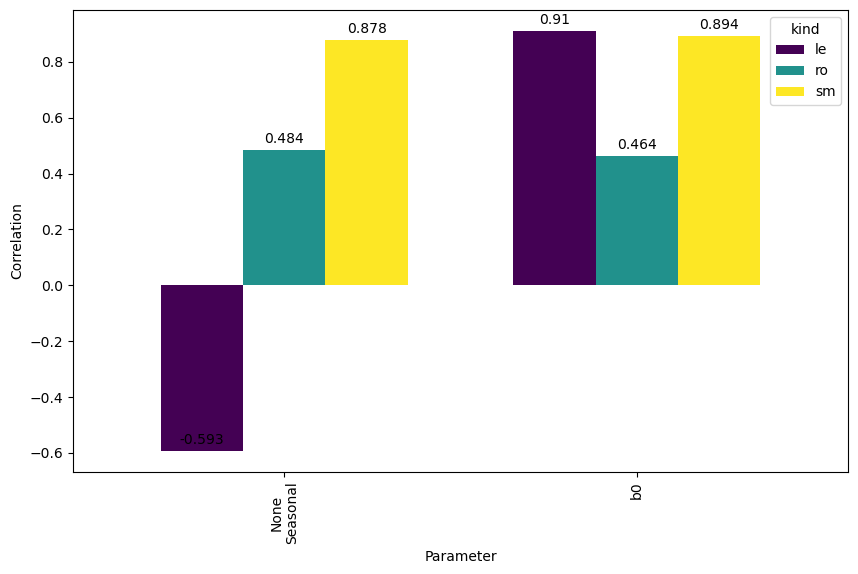

In [7]:
# PLot correlations
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr')

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(10, 6), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')

# Show the plot
plt.show()

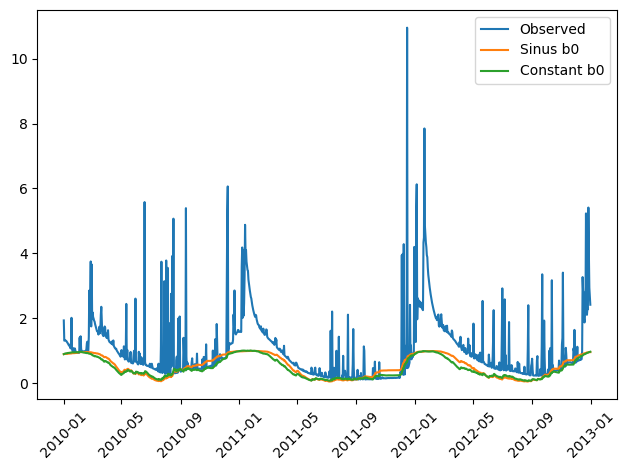

In [8]:
year_mask = [date.year == 2010 or date.year == 2011 or
             date.year == 2012 for date in input_swbm['time']]

plt.plot(input_swbm['time'][year_mask], input_swbm['ro'][year_mask],
         label='Observed')
plt.plot(input_swbm['time'][year_mask], runoffs_seasonal[year_mask],
         label='Sinus b0')
plt.plot(input_swbm['time'][year_mask], runoffs[year_mask],
         label='Constant b0')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

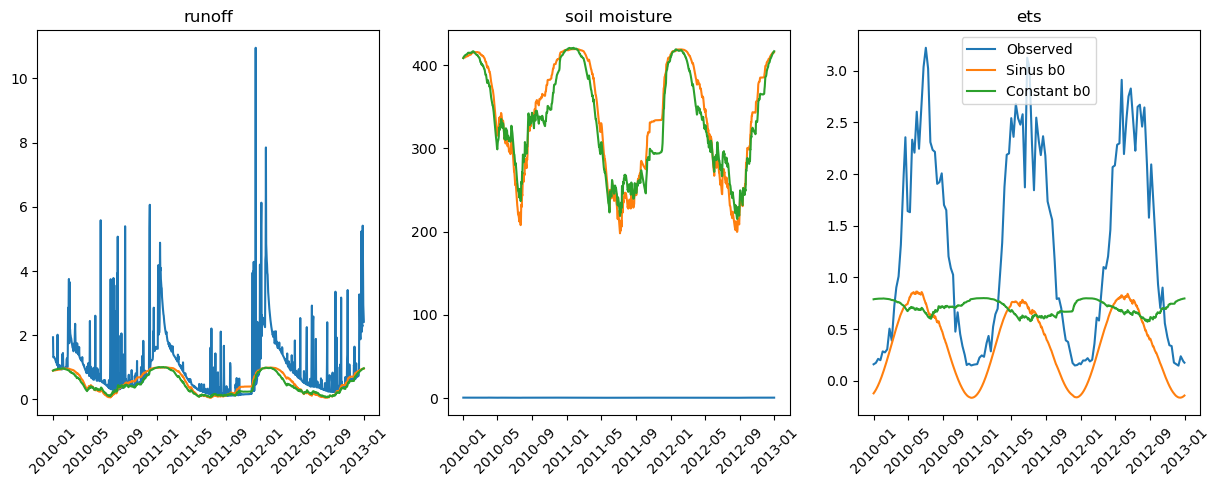

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(input_swbm['time'][year_mask], input_swbm['ro'][year_mask],
         label='Observed')
axs[0].plot(input_swbm['time'][year_mask], runoffs_seasonal[year_mask],
         label='Sinus b0')
axs[0].plot(input_swbm['time'][year_mask], runoffs[year_mask],
         label='Constant b0')
axs[0].set_title('runoff')
axs[0].tick_params(axis='x', rotation=45)

axs[1].plot(input_swbm['time'][year_mask], input_swbm['sm'][year_mask],
         label='Observed')
axs[1].plot(input_swbm['time'][year_mask], moists_seasonal[year_mask],
         label='Sinus b0')
axs[1].plot(input_swbm['time'][year_mask], moists[year_mask],
         label='Constant b0')
axs[1].set_title('soil moisture')
axs[1].tick_params(axis='x', rotation=45)

axs[2].plot(input_swbm['time'][year_mask], input_swbm['le'][year_mask],
         label='Observed')
axs[2].plot(input_swbm['time'][year_mask], ets_seasonal[year_mask],
         label='Sinus b0')
axs[2].plot(input_swbm['time'][year_mask], ets[year_mask],
         label='Constant b0')
axs[2].set_title('ets')
axs[2].tick_params(axis='x', rotation=45)
axs[2].legend()

In [11]:
input_swbm

,time,lat,long,tp,sm,ro,le,snr
0,2008-01-01,48.125,8.125,0.008255,0.378376,1.424420,0.194663,-0.473261
1,2008-01-02,48.125,8.125,0.002501,0.374456,1.378707,0.194176,-0.957191
2,2008-01-03,48.125,8.125,0.013233,0.370631,1.352798,0.193688,-0.276735
3,2008-01-04,48.125,8.125,0.000887,0.368569,1.337398,0.193201,-0.367519
4,2008-01-05,48.125,8.125,12.935702,0.385177,1.798886,0.192714,-0.037373
...,...,...,...,...,...,...,...,...
4013,2018-12-27,48.125,8.125,0.000000,0.379598,0.255905,0.162300,-0.320610
4014,2018-12-28,48.125,8.125,0.026331,0.375227,0.268236,0.160929,-0.240906
4015,2018-12-29,48.125,8.125,0.574984,0.372524,0.285736,0.159559,-0.312068
4016,2018-12-30,48.125,8.125,2.393355,0.375376,0.347551,0.158188,0.297214
